In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul 12 17:04:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   56C    P5             17W /  100W |      64MiB /   6144MiB |     26%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
from sklearn.model_selection import train_test_split

import os
from stable_baselines3.common.vec_env import DummyVecEnv

2024-07-12 17:04:23.324703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-07-12 17:04:25.249832: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-12 17:04:25.249917: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-07-12 17:04:25.417118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-12 17:04:25.421350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.605GHz coreCount: 30 deviceMemorySize: 5.70GiB deviceMemoryBandwidth: 312.97GiB/s
2024-07-12 17:04:25.421363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-07-12 17:04:25.422370: I tensorflow/stream_executor/

In [4]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1
BATCH_SIZE=140

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=40000 
LEARNING_RATE=0.001

# GYM Lunar Lander


* **Entorno**:

  Este entorno es un **problema clásico de optimización de trayectoria de un COHETE**. Según el principio del máximo de Pontryagin, es óptimo encender el motor a máxima potencia o apagarlo. Esta es la razón por la cual este entorno tiene acciones discretas: encender el motor o apagarlo.

 Existen dos versiones del entorno: discreta o continua. La plataforma de aterrizaje siempre se encuentra en las coordenadas (0,0). Las coordenadas son los primeros dos números en el vector de estado. Es posible aterrizar fuera de la plataforma de aterrizaje. El combustible es infinito, por lo que un agente puede aprender a volar y luego aterrizar en su primer intento.

* **Acciones**: tenemos cuatro acciones discretas:

  * **0**:No hacer nada
  * **1**: Encender motor de orientación izquierdo
  * **2**: Encender motor principal
  * **3**: Encender motor de orientación derecho
* **Observaciones**: es un vector de 8 dimensiones donde se almacenan las coordenadas (x,y), las velocidades lineales en x e y, su ángulo, su velocidad angular, y dos booleanos que representan si cada pata está en contacto con el suelo o no.


## Instalación de Box2D

In [5]:
!#cd pybox2d && python setup.py build && python setup.py install

In [6]:
# Definimos el entorno
env = gym.make("LunarLander-v2")

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

4
8


# Discriminador

## Red neuronal del Discriminador

In [7]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a] reales o sintéticas, de longitud ob_space.shape[0] + ac_space.n.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0] + ac_space.n )),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=10, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 10)          130       
_________________________________________________________________
layer2 (Dense)               (None, None, 10)          110       
_________________________________________________________________
layer3 (Dense)               (None, None, 10)          110       
_________________________________________________________________
prob (Dense)                 (None, None, 1)           11        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


2024-07-12 17:04:25.697227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 17:04:25.697976: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-12 17:04:25.698132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-12 17:04:25.704711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Laptop GPU computeCapability: 8.6
coreClock: 1.605GHz coreCount: 30 deviceMemorySize: 5.70GiB deviceMemoryBandwid

## Función de pérdida del Discriminador

In [8]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [9]:
# Clase DISCRIMINADOR
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, agent_s, agent_a):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net
        # -Experto: [s,a]
        self.expert_s=expert_s
        self.expert_a=expert_a
        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)

        # -Agente:  [s,a]
        self.agent_s=agent_s
        self.agent_a=agent_a
        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)



        # Calculamos la salida de la red para [s,a] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a)

        #-Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards

# Generador

## Redes neuronales del Generador

In [10]:
import keras

In [11]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,s4,...,s8]
# Output: acciones, listas de tamaño 4, a=[a1,a2,a3,a4]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=6, activation="sigmoid",name='layer1'),
        layers.Dense(units=6, activation="sigmoid", name='layer2'),
        layers.Dense(units=4, activation="sigmoid", name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 6)           54        
_________________________________________________________________
layer2 (Dense)               (None, None, 6)           42        
_________________________________________________________________
layer3 (Dense)               (None, None, 4)           28        
_________________________________________________________________
layer4 (Dense)               (None, None, 4)           20        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


In [12]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,..,s8]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None, ob_space.shape[0])),
            layers.Dense(units=6, activation="sigmoid",name='layer1'),
            layers.Dense(units=6, activation="sigmoid", name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, None, 6)           54        
_________________________________________________________________
layer2 (Dense)               (None, None, 6)           42        
_________________________________________________________________
layer3 (Dense)               (None, None, 1)           7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


## Función de pérdida del Generador

In [13]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################

def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [14]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
  def __init__(self, name: str, env, obs):
        """
        env: gym env
        obs:
        """
        # -Entorno
        self.env=env

        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0])) 
        
        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



  # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
  # La elección de la acción puede ser estocástica o determinística
  def act(self, stochastic=True):
      if stochastic:
          return self.act_stochastic, self.v_preds
      else:
          return self.act_deterministic, self.v_preds

  def get_action_prob(self):
      return self.act_probs

  def get_v_preds(self):
      return self.v_preds

  def get_obs(self):
      return self.obs

  def get_model(self):
      return self.model

  def get_trainable_variables(self):
      return self.model.get_parameters()

  # Generar [s,a] falsos
  def generate_fakes(self):

      ob_space = env.observation_space
      reward = 0
      success_num = 0


      # Por cada episodio
      for iteration in range(EPISODES):
          # Inicializo todas las variables
          observations = []
          actions = []
          rewards = []
          run_policy_steps = 0

          truncated=False
          terminated=False


          #La primera acción de cada episodio se crea con la red neuronal

          obs,_=env.reset()

          Old_Policy = Policy_net('old_policy', env, obs=obs)

          act, v_pred = Old_Policy.act(stochastic=True)

          #Convertir de tensor a array
          if type(act)=='Tensor':
              # Crear una sesión de TensorFlow
              sess = tf.compat.v1.Session()

              # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
              act = sess.run(act)

              # Cerrar la sesión
              sess.close()

          if isinstance(act, tf.Tensor):
              act=act.numpy()

          elif isinstance(act, np.ndarray):
              act=act


          action=int(act)

          next_obs,reward,terminated,truncated, info=env.step(action)

          # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
          observations.append(next_obs)  # S_0

          Policy = Policy_net('policy',env, obs=[next_obs]) # tenemos una política entrenada

          # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
          while terminated!= True and truncated!= True:
              # --Aumentar el numero de steps
              run_policy_steps += 1

              # --Política para ver la acción asociada al estado
              # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
              action, states_oc = Policy.get_model().predict(next_obs)

              action=int(action)

              # --Muevo al Agente al siguiente estado
              next_obs,reward,terminated,truncated,info=env.step(action)

              # --Actualización de variables
              actions.append(action) # A_i-1
              rewards.append(reward) # R_i-1

              # --Si llegamos a un estado final, el juego ha finalizado!!!
              # --Se configura el tablero de nuevo
              if terminated== True or truncated==True:
                  obs = env.reset()
                  reward = -1
                  break
              else:
                  observations.append(next_obs) # O_i
                  self.obs = next_obs

          # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
          if sum(rewards) >= 195:
              success_num += 1
              if success_num >= 100:
                  break
          else:
              success_num = 0


      observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
      actions = np.array(actions).astype(dtype=np.int32)


      return observations, actions, rewards, Old_Policy, Policy

In [15]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # es T-1, donde T es timestep con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# GAIL

In [16]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen=np.concatenate([generate_observations,generate_a_one_hot],axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('LunarLander-v2')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):


        # 1) Generamos secuencias falsas [s,a]
        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, (generate_observations.shape[0],ac_space.n))
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento  
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices]
        
        # 3) Obtenemos las secuencias reales [s,a] de los datos de entrenamiento y las combinamos
        combined_images = tf.concat([X_train, dataset_gen], axis=0)

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))


        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )


        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)


        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        print("\n")
        print("\nd_loss=",d_loss.numpy())
        print("\ng_loss=",g_loss.numpy())


        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}




# Experimentación de GAIL con LunarLander

## Experimento 1

In [17]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [18]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

547


In [19]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [20]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [-5.8399280e-01  5.7271480e-04  4.8840553e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.8357376e-01 -3.8873695e-03  6.6003695e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.8295580e-01 -8.0531975e-03  8.2983880e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 437
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 110


In [21]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

2024-07-12 17:05:01.781546: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


### Definición de GAIL

In [22]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [23]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


/home/usuario/miniconda3/envs/luna/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2024-06-27 17:29:39.438803: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-27 17:29:39.440618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2688000000 Hz





d_loss= 2.5869877

g_loss= -1.7489645
1/4 [======>.......................] - ETA: 43:02 - d_loss: 2.5870 - g_loss: -1.7490


d_loss= 2.5900705

g_loss= 0.52555335
2/4 [==============>...............] - ETA: 24:03 - d_loss: 2.5885 - g_loss: -0.6117


d_loss= 2.5642223

g_loss= 3.6435153
3/4 [=====================>........] - ETA: 11:28 - d_loss: 2.5804 - g_loss: 0.8067 


d_loss= 2.607141

g_loss= 1.4808834
4/4 [==============================] - 2900s 680s/step - d_loss: 2.5871 - g_loss: 0.9752


### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.6708 - accuracy: 0.2793
>Loss real: 
0.6473046541213989
>Loss fake: 
0.6707906723022461


Episode  0 Total reward: -303.03492990060806
Episode  1 Total reward: -168.20274883198556
Episode  2 Total reward: -179.3666313009898
Episode  3 Total reward: -46.50638557855475
Episode  4 Total reward: 7.513713376916925
Episode  5 Total reward: -136.86628345513495
Episode  6 Total reward: 92.63721737952575
Episode  7 Total reward: 11.082990495718747
Episode  8 Total reward: 0.15854956393062025
Episode  9 Total reward: -18.34278456052779
Episode  10 Total reward: -212.06455805202245
Episode  11 Total reward: -235.99362173925113
Episode  12 Total reward: -263.2170792909418
Episode  13 Total reward: -52.540531212556544
Episode  14 Total reward: -123.84125642845201
Episode  15 Total reward: -57.73309316897304
Episode  16 Total reward: -105.81570415275837
Episode  17 Total reward: -33.771759619632746
Episode  18 Total reward: 8.498855578062333
Episode  19 Total reward: -4.260664747044885
Episode  20 Total reward: -227.2405688395984
Episode  21 Total reward: -68.5609425619273
Episode  22 To

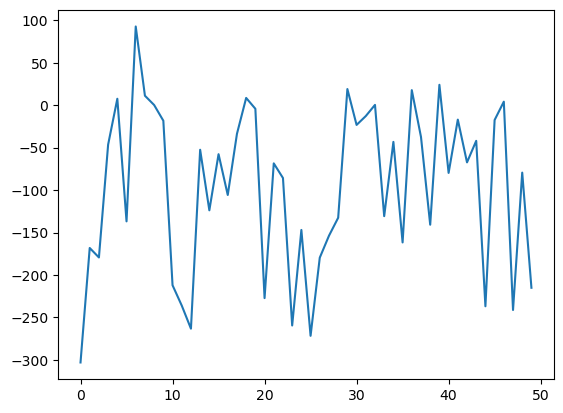


Recompensa de Media: -96.57827728546286 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2

In [27]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [28]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

1127


In [29]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [30]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 5.7585880e-01 -1.8368971e-01 -2.2056554e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.7585880e-01 -1.8368971e-01 -3.6117143e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.7585880e-01 -1.8368971e-01 -4.6132280e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 901
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 226


In [31]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [32]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [33]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140 

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.604107

g_loss= 1.6006018
1/7 [===>..........................] - ETA: 1:05:49 - d_loss: 2.6041 - g_loss: 1.6006


d_loss= 2.559779

g_loss= -2.7332942
2/7 [=======>......................] - ETA: 54:48 - d_loss: 2.5819 - g_loss: -0.5663 


d_loss= 2.5663247

g_loss= 1.5805186
3/7 [===========>..................] - ETA: 43:50 - d_loss: 2.5767 - g_loss: 0.1493 


d_loss= 2.5866117

g_loss= 1.9192059
4/7 [================>.............] - ETA: 32:57 - d_loss: 2.5792 - g_loss: 0.5918


d_loss= 2.5854042

g_loss= 0.6082139
5/7 [====================>.........] - ETA: 21:59 - d_loss: 2.5804 - g_loss: 0.5950


d_loss= 2.5499654

g_loss= 2.6718738
6/7 [========================>.....] - ETA: 10:59 - d_loss: 2.5754 - g_loss: 0.9412


d_loss= 2.541269

g_loss= -3.822152
7/7 [==============================] - 4616s 660s/step - d_loss: 2.5705 - g_loss: 0.2607


### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.6427 - accuracy: 0.0460
>Loss real: 
0.6281254887580872
>Loss fake: 
0.6427103281021118


Episode  0 Total reward: -47.25210251823657
Episode  1 Total reward: -204.72213546560835
Episode  2 Total reward: 82.81588684362062
Episode  3 Total reward: -103.40654121304466
Episode  4 Total reward: 65.39174037662697
Episode  5 Total reward: -209.14573608762905
Episode  6 Total reward: -43.935913827620524
Episode  7 Total reward: 120.45478910979153
Episode  8 Total reward: -63.833853269447175
Episode  9 Total reward: -24.907417082563583
Episode  10 Total reward: -4.134985556938093
Episode  11 Total reward: 45.72158619166423
Episode  12 Total reward: -86.64157478852984
Episode  13 Total reward: -66.5651842822478
Episode  14 Total reward: -115.23042087964134
Episode  15 Total reward: 33.539963352721884
Episode  16 Total reward: -117.32464000540905
Episode  17 Total reward: -57.07664935140778
Episode  18 Total reward: 9.293299678076195
Episode  19 Total reward: -98.00023557363355
Episode  20 Total reward: 55.49245671494538
Episode  21 Total reward: 103.13735933320339
Episode  22 Total 

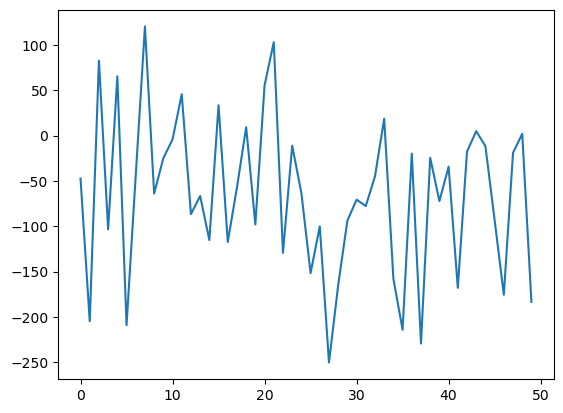


Recompensa de Media: -65.5840110086576 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3

In [37]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [38]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1572


In [39]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [40]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [ 0.4179185   0.11636597 -0.10107721 ...  0.          1.
   0.        ]
 [ 0.41688195  0.11385406 -0.10168035 ...  0.          1.
   0.        ]
 [ 0.41580305  0.11141074 -0.10570452 ...  0.          1.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1257
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 315


In [41]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [42]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [43]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.5267668

g_loss= -0.87284565
1/9 [==>...........................] - ETA: 1:27:38 - d_loss: 2.5268 - g_loss: -0.8728


d_loss= 2.553796

g_loss= 1.3850619
2/9 [=====>........................] - ETA: 1:16:12 - d_loss: 2.5403 - g_loss: 0.2561 


d_loss= 2.5088708

g_loss= -3.0662274
3/9 [=========>....................] - ETA: 1:05:32 - d_loss: 2.5298 - g_loss: -0.8513


d_loss= 2.5280404

g_loss= -1.6360327
4/9 [============>.................] - ETA: 54:43 - d_loss: 2.5294 - g_loss: -1.0475  


d_loss= 2.4858227

g_loss= -3.5558338
5/9 [===============>..............] - ETA: 43:47 - d_loss: 2.5207 - g_loss: -1.5492


d_loss= 2.482568

g_loss= -0.342203
6/9 [===================>..........] - ETA: 32:51 - d_loss: 2.5143 - g_loss: -1.3480


d_loss= 2.4920928

g_loss= -3.0979366
7/9 [======================>.......] - ETA: 21:55 - d_loss: 2.5111 - g_loss: -1.5980


d_loss= 2.4426517

g_loss= -2.161507
8/9 [=========================>....] - ETA: 10:58 - d_loss: 2.5026 - g_loss: -1.

### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)


1/1 [==============================] - 0s 17ms/step - loss: 0.6328 - accuracy: 0.0473
>Loss real: 
0.5857214331626892
>Loss fake: 
0.6327922344207764


Episode  0 Total reward: -101.52949299712319
Episode  1 Total reward: -232.4943924962734
Episode  2 Total reward: -132.50555245188207
Episode  3 Total reward: -54.30043973842365
Episode  4 Total reward: -0.5579515216308724
Episode  5 Total reward: -18.573043049059663
Episode  6 Total reward: -151.86069515279752
Episode  7 Total reward: -27.985945628395427
Episode  8 Total reward: -210.06828832648216
Episode  9 Total reward: 114.33270173525551
Episode  10 Total reward: -165.4575183218056
Episode  11 Total reward: -111.20829032146018
Episode  12 Total reward: -31.9270046747002
Episode  13 Total reward: -158.69579469168926
Episode  14 Total reward: -50.68034828520197
Episode  15 Total reward: 82.18635080632374
Episode  16 Total reward: -66.5591843755714
Episode  17 Total reward: -125.10344056239742
Episode  18 Total reward: -88.94425184853378
Episode  19 Total reward: 20.43669740667498
Episode  20 Total reward: -183.97423178289284
Episode  21 Total reward: -156.11094020797435
Episode  22 

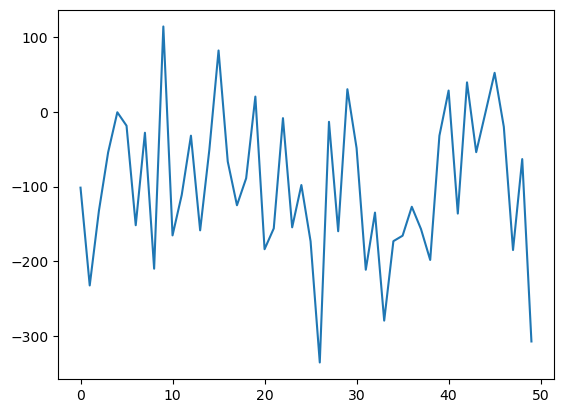


Recompensa de Media: -98.79758398966896 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4

In [47]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [48]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

2168


In [49]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [50]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 4.1053313e-01  4.4803914e-02  2.5128000e-04 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [ 4.1053715e-01  4.4805490e-02  4.1009445e-04 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [ 4.1053790e-01  4.4805700e-02  7.5154120e-05 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1734
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 434


In [51]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [52]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [53]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [54]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.5217714

g_loss= 0.8984853
 1/13 [=>............................] - ETA: 2:05:00 - d_loss: 2.5218 - g_loss: 0.8985


d_loss= 2.5136316

g_loss= 1.6746728
 2/13 [===>..........................] - ETA: 1:55:23 - d_loss: 2.5177 - g_loss: 1.2866


d_loss= 2.492674

g_loss= 2.2678258
 3/13 [=====>........................] - ETA: 1:45:00 - d_loss: 2.5094 - g_loss: 1.6137


d_loss= 2.4709368

g_loss= 1.236708
 4/13 [========>.....................] - ETA: 1:34:18 - d_loss: 2.4998 - g_loss: 1.5194


d_loss= 2.479061

g_loss= 1.9631789
 5/13 [==========>...................] - ETA: 1:23:40 - d_loss: 2.4956 - g_loss: 1.6082


d_loss= 2.4247127

g_loss= 1.6669004
 6/13 [============>.................] - ETA: 1:13:14 - d_loss: 2.4838 - g_loss: 1.6180


d_loss= 2.4772315

g_loss= 0.9903895
 7/13 [===============>..............] - ETA: 1:02:41 - d_loss: 2.4829 - g_loss: 1.5283


d_loss= 2.5200577

g_loss= -4.8121686
 8/13 [=================>............] - ETA: 52:18 - d_loss: 2.4875 - g_

### Evaluación de GAIL

In [55]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.5568 - accuracy: 0.0000e+00
>Loss real: 
0.5431392192840576
>Loss fake: 
0.5567510724067688


Episode  0 Total reward: -54.20825290083791
Episode  1 Total reward: -162.99330675209058
Episode  2 Total reward: -66.27367063475367
Episode  3 Total reward: -27.54266584816969
Episode  4 Total reward: -208.401413554015
Episode  5 Total reward: -235.75084512136854
Episode  6 Total reward: -50.25839325993794
Episode  7 Total reward: -224.19374045835272
Episode  8 Total reward: -114.16990580848648
Episode  9 Total reward: 72.7215931228074
Episode  10 Total reward: -18.665888713077734
Episode  11 Total reward: -255.52076729864928
Episode  12 Total reward: -41.596421053280736
Episode  13 Total reward: -22.9112045942545
Episode  14 Total reward: -117.73160927712738
Episode  15 Total reward: -355.00839640176736
Episode  16 Total reward: -243.54899239909486
Episode  17 Total reward: -50.40647968907727
Episode  18 Total reward: 103.03426574561087
Episode  19 Total reward: -149.55630960485053
Episode  20 Total reward: -252.67163948685803
Episode  21 Total reward: 3.6167583064808753
Episode  22 

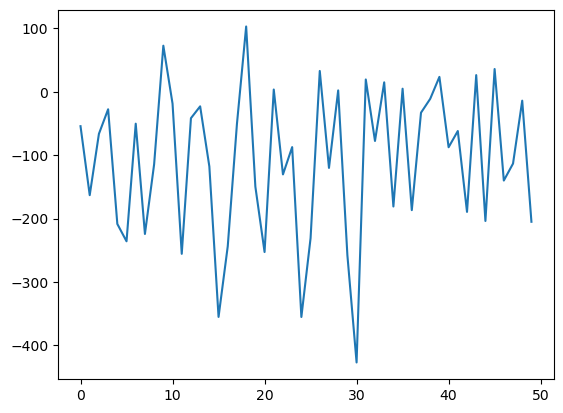


Recompensa de Media: -108.46123324827724 



In [56]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5

In [57]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [58]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

3158


In [59]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [60]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 6.7724630e-01  4.2385206e-02  5.4524446e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.7724630e-01  4.2385206e-02  1.1408074e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.7724630e-01  4.2385206e-02 -2.4774107e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2526
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 632


In [61]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [62]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [63]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [64]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BACH_SIZE=140

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.4343314

g_loss= 1.5278764
 1/19 [>.............................] - ETA: 3:09:05 - d_loss: 2.4343 - g_loss: 1.5279


d_loss= 2.4124234

g_loss= -0.27539796
 2/19 [==>...........................] - ETA: 2:56:55 - d_loss: 2.4234 - g_loss: 0.6262


d_loss= 2.4415345

g_loss= 18.510502
 3/19 [===>..........................] - ETA: 2:46:47 - d_loss: 2.4294 - g_loss: 6.5877


d_loss= 2.4619584

g_loss= -8.8781395
 4/19 [=====>........................] - ETA: 2:36:40 - d_loss: 2.4376 - g_loss: 2.7212


d_loss= 2.3897276

g_loss= 2.8796005
 5/19 [======>.......................] - ETA: 2:26:20 - d_loss: 2.4280 - g_loss: 2.7529


d_loss= 2.4453418

g_loss= 0.30010137
 6/19 [========>.....................] - ETA: 2:16:01 - d_loss: 2.4309 - g_loss: 2.3441


d_loss= 2.4018302

g_loss= 1.0802525
 7/19 [==========>...................] - ETA: 2:05:25 - d_loss: 2.4267 - g_loss: 2.1635


d_loss= 2.414916

g_loss= 1.4099278
 8/19 [===========>..................] - ETA: 1:55:19 - d_loss: 2.42

### Evaluación de GAIL

In [65]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)


1/1 [==============================] - 0s 17ms/step - loss: 0.4665 - accuracy: 0.0000e+00
>Loss real: 
0.451355516910553
>Loss fake: 
0.466470330953598


Episode  0 Total reward: -298.3945447263211
Episode  1 Total reward: -164.23609745024788
Episode  2 Total reward: -107.81198103420482
Episode  3 Total reward: -320.88997250565717
Episode  4 Total reward: -375.93051601082954
Episode  5 Total reward: -36.73947718341324
Episode  6 Total reward: -213.38721047202625
Episode  7 Total reward: -189.7392966767975
Episode  8 Total reward: -30.69862643466186
Episode  9 Total reward: -177.24804970303217
Episode  10 Total reward: -273.2161658549089
Episode  11 Total reward: 4.942351667643138
Episode  12 Total reward: -171.92843898863217
Episode  13 Total reward: -254.88675591411757
Episode  14 Total reward: -162.8742878108209
Episode  15 Total reward: -161.90883732369753
Episode  16 Total reward: -242.027023140809
Episode  17 Total reward: -6.290773652543422
Episode  18 Total reward: 0.41413265961604395
Episode  19 Total reward: -273.76395363185856
Episode  20 Total reward: -165.4052353733231
Episode  21 Total reward: -14.77808816944291
Episode  22

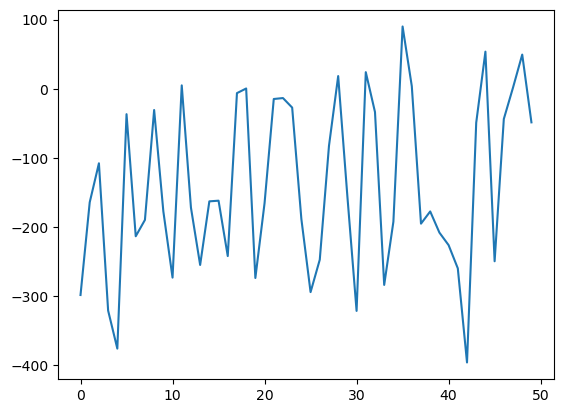


Recompensa de Media: -141.7837991219365 



In [66]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6

In [67]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [68]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

4158


In [69]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [70]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 3.2675964e-01 -5.1517500e-02 -1.6227339e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2676880e-01 -5.1521648e-02  9.4594294e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2677516e-01 -5.1524438e-02  6.5785140e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3326
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 832


In [71]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [72]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [73]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.3414257

g_loss= 0.96710724
 1/24 [>.............................] - ETA: 4:15:53 - d_loss: 2.3414 - g_loss: 0.9671


d_loss= 2.3479059

g_loss= -1.4936949
 2/24 [=>............................] - ETA: 4:02:38 - d_loss: 2.3447 - g_loss: -0.2633


d_loss= 2.3826447

g_loss= 1.0446305
 3/24 [==>...........................] - ETA: 3:52:05 - d_loss: 2.3573 - g_loss: 0.1727 


d_loss= 2.3714185

g_loss= 3.3770418
 4/24 [====>.........................] - ETA: 3:40:52 - d_loss: 2.3608 - g_loss: 0.9738


d_loss= 2.3258386

g_loss= 1.0362056
 5/24 [=====>........................] - ETA: 3:29:13 - d_loss: 2.3538 - g_loss: 0.9863


d_loss= 2.3327937

g_loss= 2.4594426
 6/24 [======>.......................] - ETA: 3:18:24 - d_loss: 2.3503 - g_loss: 1.2318


d_loss= 2.368942

g_loss= -1.1463125
 7/24 [=======>......................] - ETA: 3:07:21 - d_loss: 2.3530 - g_loss: 0.8921


d_loss= 2.3329632

g_loss= 2.8110087
 8/24 [=========>....................] - ETA: 2:56:12 - d_loss: 2.3

### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.3245 - accuracy: 0.0000e+00
>Loss real: 
0.3653477132320404
>Loss fake: 
0.32447341084480286


Episode  0 Total reward: -34.17219786437799
Episode  1 Total reward: -111.21136760945579
Episode  2 Total reward: -148.40356410631492
Episode  3 Total reward: -175.13759623310307
Episode  4 Total reward: -29.886574104313553
Episode  5 Total reward: -63.63486504632145
Episode  6 Total reward: 49.54819546558909
Episode  7 Total reward: -18.066027715507616
Episode  8 Total reward: -11.243037938700724
Episode  9 Total reward: -86.09092443144581
Episode  10 Total reward: 41.076087776643575
Episode  11 Total reward: -491.5942740021038
Episode  12 Total reward: -180.39053690898362
Episode  13 Total reward: -198.74965365102298
Episode  14 Total reward: 24.06399390260985
Episode  15 Total reward: -55.5058455088423
Episode  16 Total reward: -153.7564036789256
Episode  17 Total reward: -49.20484354078064
Episode  18 Total reward: -6.136118106388665
Episode  19 Total reward: 44.6657662435809
Episode  20 Total reward: 12.308700287859622
Episode  21 Total reward: -69.21487559373718
Episode  22 Total

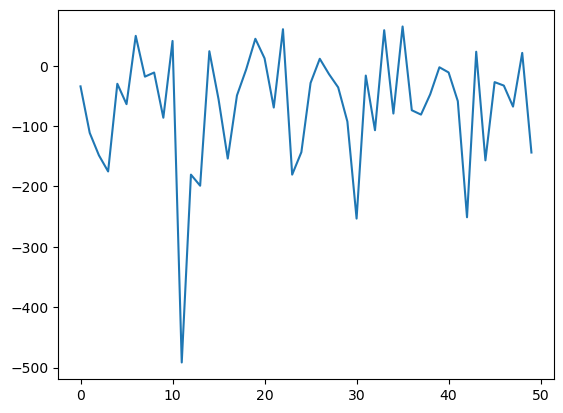


Recompensa de Media: -67.4671596553166 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7

In [77]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [78]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

4680


In [79]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [80]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [-8.6160660e-03 -1.2264752e-03  5.3442470e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.6160660e-03 -1.2264752e-03  4.7162676e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.6160660e-03 -1.2264752e-03  3.9814470e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3744
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 936


In [81]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [82]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [83]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL:111 Julio

In [84]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.1992164

g_loss= 10.078086
 1/27 [>.............................] - ETA: 4:30:20 - d_loss: 2.1992 - g_loss: 10.0781


d_loss= 2.249517

g_loss= -4.19089
 2/27 [=>............................] - ETA: 4:19:44 - d_loss: 2.2244 - g_loss: 2.9436 


d_loss= 2.21242

g_loss= -0.12890892
 3/27 [==>...........................] - ETA: 4:09:25 - d_loss: 2.2204 - g_loss: 1.9194


d_loss= 2.2858357

g_loss= -2.8192253
 4/27 [===>..........................] - ETA: 3:59:17 - d_loss: 2.2367 - g_loss: 0.7348


d_loss= 2.2605193

g_loss= 1.2253541
 5/27 [====>.........................] - ETA: 3:48:54 - d_loss: 2.2415 - g_loss: 0.8329


d_loss= 2.2681231

g_loss= -1.2698212
 6/27 [=====>........................] - ETA: 3:38:34 - d_loss: 2.2459 - g_loss: 0.4824


d_loss= 2.2129128

g_loss= 1.6878016
 7/27 [======>.......................] - ETA: 3:28:19 - d_loss: 2.2412 - g_loss: 0.6546


d_loss= 2.2129898

g_loss= 1.7571399
 8/27 [=======>......................] - ETA: 3:18:09 - d_loss: 2.237

### Evaluación de GAIL

In [85]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)


1/1 [==============================] - 0s 16ms/step - loss: 0.1936 - accuracy: 0.0000e+00
>Loss real: 
0.2307622730731964
>Loss fake: 
0.19357889890670776


Episode  0 Total reward: 18.0909552986447
Episode  1 Total reward: 103.35687758858653
Episode  2 Total reward: -106.08590090110218
Episode  3 Total reward: -143.48157179585914
Episode  4 Total reward: -98.08062383464538
Episode  5 Total reward: -13.408817955237012
Episode  6 Total reward: -99.73177979132724
Episode  7 Total reward: -136.07280040497568
Episode  8 Total reward: -79.50307598766135
Episode  9 Total reward: -151.283592214906
Episode  10 Total reward: -114.12171241442475
Episode  11 Total reward: -9.813204410815372
Episode  12 Total reward: -52.84044604760258
Episode  13 Total reward: -129.2309672909768
Episode  14 Total reward: -43.920812489632524
Episode  15 Total reward: -68.67577157058041
Episode  16 Total reward: -250.14027687471452
Episode  17 Total reward: 64.27896695671461
Episode  18 Total reward: 0.6913754430051142
Episode  19 Total reward: -153.8014312844716
Episode  20 Total reward: -172.12293498243355
Episode  21 Total reward: -135.58202288150733
Episode  22 Tot

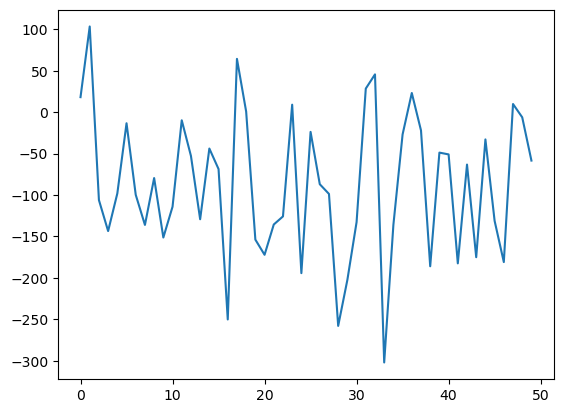


Recompensa de Media: -87.62727876953228 



In [86]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8

In [87]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [88]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

5314


In [89]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [90]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 1.3379402e-01  3.4672476e-03  6.3765560e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3379402e-01  3.4672476e-03  5.2665534e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3379402e-01  3.4672476e-03  4.0811244e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4251
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1063


In [91]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [92]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [93]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [94]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.168239

g_loss= -1.4352854
 1/31 [..............................] - ETA: 5:12:41 - d_loss: 2.1682 - g_loss: -1.4353


d_loss= 2.0973063

g_loss= 1.3332803
 2/31 [>.............................] - ETA: 5:00:32 - d_loss: 2.1328 - g_loss: -0.0510


d_loss= 2.1293163

g_loss= 2.947773
 3/31 [=>............................] - ETA: 4:50:40 - d_loss: 2.1316 - g_loss: 0.9486 


d_loss= 2.0864708

g_loss= 0.13356198
 4/31 [==>...........................] - ETA: 4:40:47 - d_loss: 2.1203 - g_loss: 0.7448


d_loss= 2.1361542

g_loss= 0.8342664
 5/31 [===>..........................] - ETA: 4:30:38 - d_loss: 2.1235 - g_loss: 0.7627


d_loss= 2.0865173

g_loss= 2.2215557
 6/31 [====>.........................] - ETA: 4:20:19 - d_loss: 2.1173 - g_loss: 1.0059


d_loss= 2.168545

g_loss= -0.67755616
 7/31 [=====>........................] - ETA: 4:09:58 - d_loss: 2.1246 - g_loss: 0.7654


d_loss= 2.1142564

g_loss= -0.58131045
 8/31 [======>.......................] - ETA: 3:59:34 - d_loss: 2

### Evaluación de GAIL

In [95]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.1662 - accuracy: 0.0000e+00
>Loss real: 
0.12309325486421585
>Loss fake: 
0.16621606051921844


Episode  0 Total reward: -152.45009046059357
Episode  1 Total reward: -74.89542898525761
Episode  2 Total reward: -11.157863982855304
Episode  3 Total reward: 16.37162805211814
Episode  4 Total reward: -170.3722071823641
Episode  5 Total reward: -46.137262062290176
Episode  6 Total reward: -20.01862610234552
Episode  7 Total reward: 122.21944293946487
Episode  8 Total reward: -83.05436230042258
Episode  9 Total reward: -0.9943218218144949
Episode  10 Total reward: -62.66975753694601
Episode  11 Total reward: 15.973213687691654
Episode  12 Total reward: -225.55737642988464
Episode  13 Total reward: 65.54877113255475
Episode  14 Total reward: -32.988570473580324
Episode  15 Total reward: -147.17366453085322
Episode  16 Total reward: -82.63414304177783
Episode  17 Total reward: 84.80732250233072
Episode  18 Total reward: -27.64896351257441
Episode  19 Total reward: -12.68855178285942
Episode  20 Total reward: -63.75141252568549
Episode  21 Total reward: -27.602924876692015
Episode  22 Tot

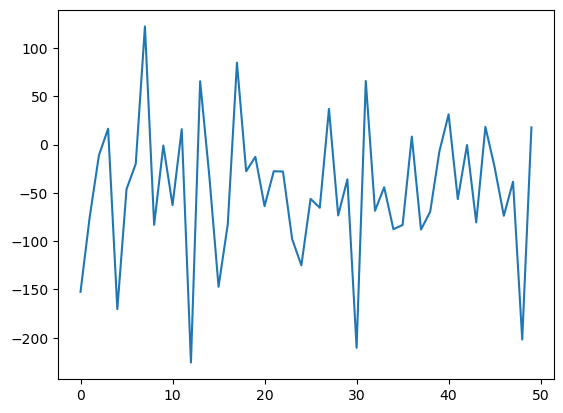


Recompensa de Media: -47.473945992231286 



In [96]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9

In [97]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [98]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

5799


In [99]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [100]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [ 0.7474047   0.0260748  -0.02635835 ...  0.          0.
   0.        ]
 [ 0.74719274  0.02124918 -0.04889769 ...  0.          0.
   1.        ]
 [ 0.74685365  0.01683348 -0.05817185 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4639
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1160


In [101]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [102]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [103]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL:11 Julio

In [104]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.0391202

g_loss= 1.1080501
 1/34 [..............................] - ETA: 5:44:40 - d_loss: 2.0391 - g_loss: 1.1081


d_loss= 2.041652

g_loss= -1.2417939
 2/34 [>.............................] - ETA: 5:33:02 - d_loss: 2.0404 - g_loss: -0.0669


d_loss= 2.027039

g_loss= 0.4549353
 3/34 [=>............................] - ETA: 5:22:34 - d_loss: 2.0359 - g_loss: 0.1071 


d_loss= 1.9740076

g_loss= 0.46649015
 4/34 [==>...........................] - ETA: 5:12:35 - d_loss: 2.0205 - g_loss: 0.1969


d_loss= 2.0070426

g_loss= 0.46563444
 5/34 [===>..........................] - ETA: 5:02:17 - d_loss: 2.0178 - g_loss: 0.2507


d_loss= 2.0025592

g_loss= 1.4233248
 6/34 [====>.........................] - ETA: 4:51:44 - d_loss: 2.0152 - g_loss: 0.4461


d_loss= 1.9986088

g_loss= 4.420643
 7/34 [=====>........................] - ETA: 4:41:05 - d_loss: 2.0129 - g_loss: 1.0139


d_loss= 2.059896

g_loss= 1.0117975
 8/34 [======>.......................] - ETA: 4:30:35 - d_loss: 2.0187

### Evaluación de GAIL

In [105]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.1045 - accuracy: 0.0000e+00
>Loss real: 
0.04666326195001602
>Loss fake: 
0.10448182374238968


Episode  0 Total reward: -177.47390024851904
Episode  1 Total reward: -272.60068566981835
Episode  2 Total reward: -107.72785221370978
Episode  3 Total reward: -45.018073822298135
Episode  4 Total reward: -87.18656115306928
Episode  5 Total reward: -31.240055607665454
Episode  6 Total reward: -365.4599872459789
Episode  7 Total reward: -74.20741250291458
Episode  8 Total reward: 36.155331179445824
Episode  9 Total reward: -18.954097411832393
Episode  10 Total reward: -34.28525369274209
Episode  11 Total reward: -39.21565407014517
Episode  12 Total reward: 21.296126863052592
Episode  13 Total reward: -203.9683886198651
Episode  14 Total reward: 87.51771659343427
Episode  15 Total reward: -101.72806977211054
Episode  16 Total reward: -51.224192104087535
Episode  17 Total reward: -58.160385243537036
Episode  18 Total reward: -34.88016611510744
Episode  19 Total reward: 52.6848961516693
Episode  20 Total reward: -38.34661337209373
Episode  21 Total reward: -13.729260711412943
Episode  22 T

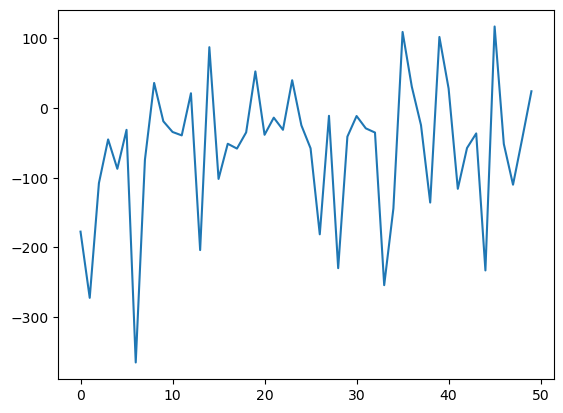


Recompensa de Media: -59.30802642311175 



In [106]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10

In [107]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [108]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

6310


In [109]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [110]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.          0.
   0.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.          0.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 5048
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1262


In [111]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)
BATCH_SIZE= round(len(X_train)/300)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [112]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [113]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [ ]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE=140

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)





d_loss= 2.2263265

g_loss= 1.2751336
 1/37 [..............................] - ETA: 6:06:21 - d_loss: 2.2263 - g_loss: 1.2751


d_loss= 2.253498

g_loss= 0.6420274
 2/37 [>.............................] - ETA: 6:01:30 - d_loss: 2.2399 - g_loss: 0.9586


d_loss= 2.2413805

g_loss= 10.210431
 3/37 [=>............................] - ETA: 5:49:33 - d_loss: 2.2404 - g_loss: 4.0425


d_loss= 2.1521301

g_loss= 1.540593
 4/37 [==>...........................] - ETA: 5:40:09 - d_loss: 2.2183 - g_loss: 3.4170


d_loss= 2.2152104

g_loss= 9.263229
 5/37 [===>..........................] - ETA: 5:29:11 - d_loss: 2.2177 - g_loss: 4.5863


d_loss= 2.1911702

g_loss= 2.8035722
 6/37 [===>..........................] - ETA: 5:19:41 - d_loss: 2.2133 - g_loss: 4.2892


d_loss= 2.1430357

g_loss= 1.3909442
 7/37 [====>.........................] - ETA: 5:09:16 - d_loss: 2.2033 - g_loss: 3.8751


d_loss= 2.180944

g_loss= 0.62355936
 8/37 [=====>........................] - ETA: 4:58:34 - d_loss: 2.2005 - g

### Evaluación de GAIL

In [ ]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)


1/1 [==============================] - 0s 17ms/step - loss: 0.0339 - accuracy: 0.0000e+00
>Loss real: 
0.10895921289920807
>Loss fake: 
0.03391684964299202


Episode  0 Total reward: 150.522584842905
Episode  1 Total reward: -259.45595668292947
Episode  2 Total reward: -78.02488009935205
Episode  3 Total reward: -112.00692898484239
Episode  4 Total reward: -88.8993516939883
Episode  5 Total reward: -226.18427510426352
Episode  6 Total reward: -14.44569921242946
Episode  7 Total reward: 72.54648837965871
Episode  8 Total reward: 4.400215522839304
Episode  9 Total reward: -109.32725738220782
Episode  10 Total reward: -98.77935435089992
Episode  11 Total reward: -47.52661631099828
Episode  12 Total reward: 25.954252129439567
Episode  13 Total reward: -76.4951869285387
Episode  14 Total reward: -20.531004211628115
Episode  15 Total reward: -42.59974087142177
Episode  16 Total reward: -77.7222007662748
Episode  17 Total reward: -96.0532054396848
Episode  18 Total reward: -11.08146533116249
Episode  19 Total reward: -281.7259366549191
Episode  20 Total reward: 202.18187661245054
Episode  21 Total reward: 58.677337362824986
Episode  22 Total rewar

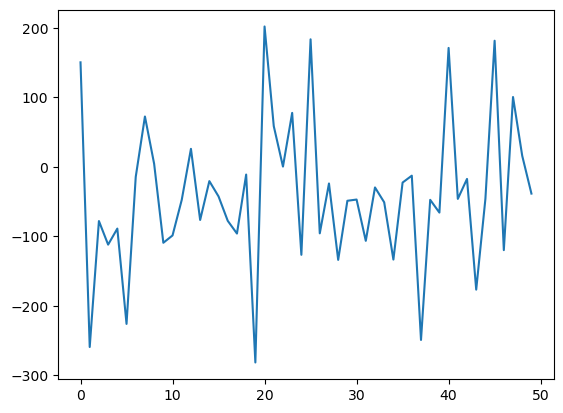


Recompensa de Media: -40.69550904048097 



In [ ]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')